# Prepare custom dataset

In [34]:
# Copyright 2021 wngfra.
# SPDX-License-Identifier: Apache-2.0

import glob
import os
import re
import numpy as np
from bidict import bidict
from numpy.lib.stride_tricks import sliding_window_view
from torch.utils.data import Dataset
from torchvision import transforms

class Texture:
    """ Create a bidict from a texture name list."""

    def __init__(self, texture_names):
        self.texture_by_id = bidict()
        for i, tn in enumerate(set(texture_names)):
            self.texture_by_id[tn] = i

    def get_id(self, texture_name: str):
        return self.texture_by_id[texture_name]

    def get_name(self, texture_id: int):
        return self.texture_by_id.inverse[texture_id]


class TacDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.filelist = [y for x in os.walk(
            root_dir) for y in glob.glob(os.path.join(x[0], '*.npy'))]
        self.params = [(0.0, 0.0)] * len(self.filelist)
        self.texture_names = []
        for i, filename in enumerate(self.filelist):
            basename = os.path.basename(filename)
            namegroups = basename.split('_')

            self.texture_names.append(namegroups[0])
            self.params[i] = [float(re.search(r"\d+.\d+", namegroups[1]).group(0)),
                              float(re.search(r"-?\d+.\d+", namegroups[2]).group(0))]
        self.textures = Texture(self.texture_names)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        filename = os.path.join(self.root_dir, self.filelist[index])
        rawdata  = np.load(filename)
        tacdata  = rawdata[64:-64, :16]
        # wrench   = rawdata[:, -6:]
        texture_name = self.texture_names[index]
        if self.transform:
            tacdata = self.transform(tacdata)
        return tacdata, self.params[index], self.textures.get_id(texture_name) 

    def get_texture_name(self, texture_id):
        return self.textures.get_name(texture_id)

    
""" Custom transforms """
from skfda import FDataGrid
from skfda.representation import basis

class Normalize(object):
    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, sample):
        return (sample - np.mean(sample, axis=self.axis, keepdims=True)) / np.std(sample, axis=self.axis, keepdims=True)
    
class ToFDA(object):
    def __init__(self, basis, flatten=True):
        self.basis = basis
        self.flatten = flatten
    
    def __call__(self, x):
        ''' Compute covariance matrix with functional basis decomposition.'''
        fd = FDataGrid(x.T).to_basis(self.basis)
        coeffs = fd.coefficients.squeeze()
        coeffs = coeffs[:, 1:].T
        if self.flatten:
            coeffs = coeffs.flatten()
        
        return coeffs

fd_basis = basis.Fourier([0, 2 * np.pi], n_basis=33, period=1)
transform = transforms.Compose([Normalize(axis=1), ToFDA(basis=fd_basis, flatten=False)])
ds = TacDataset('../data', transform=transform)

# Plot raw data

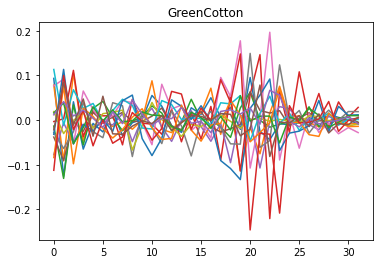

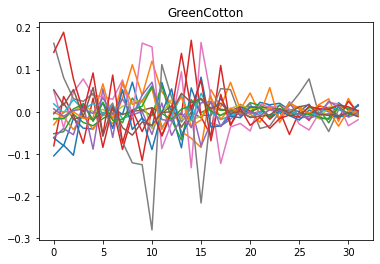

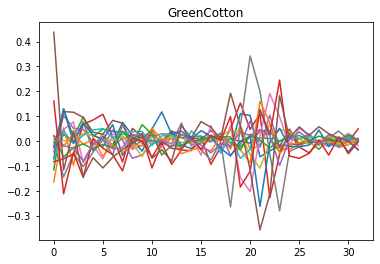

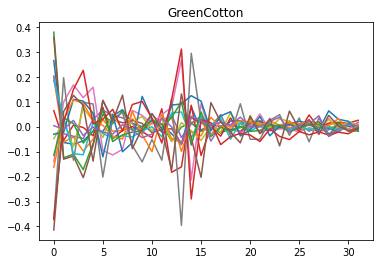

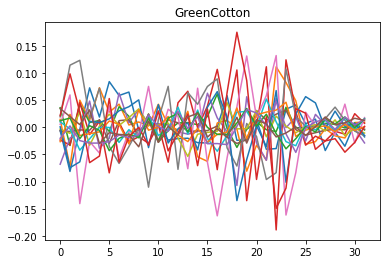

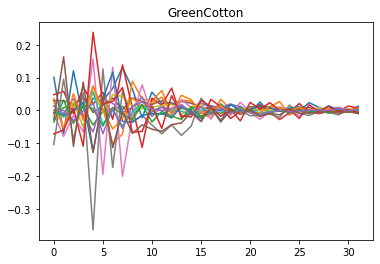

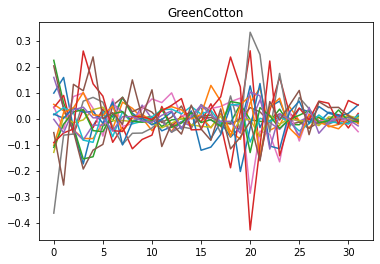

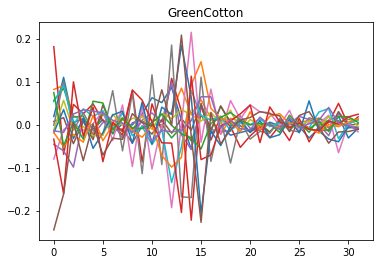

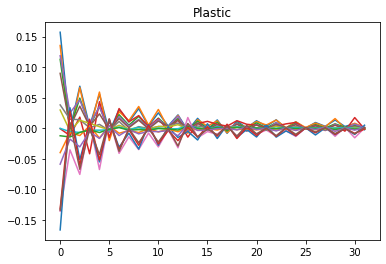

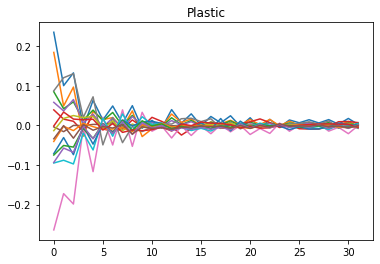

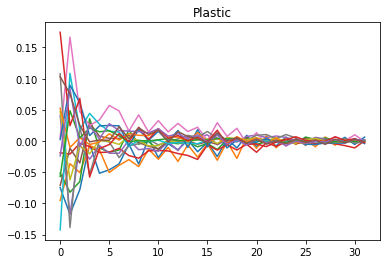

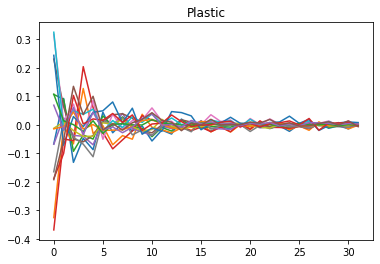

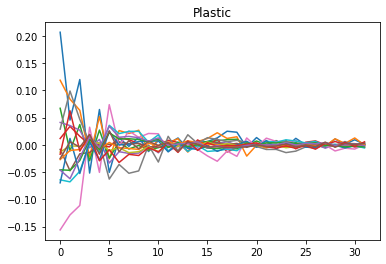

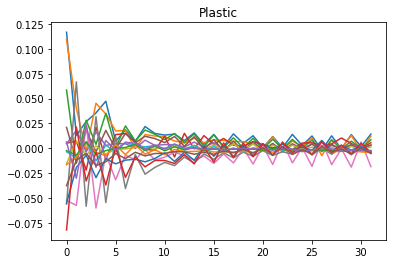

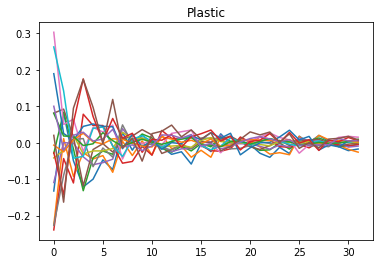

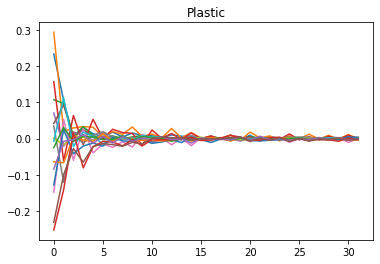

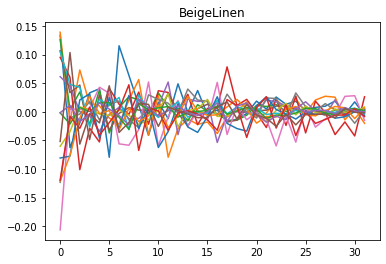

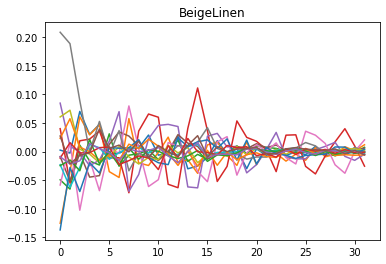

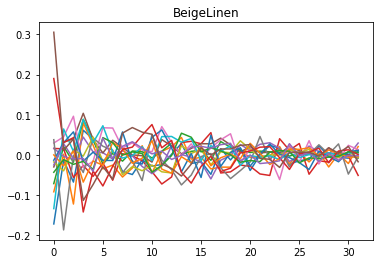

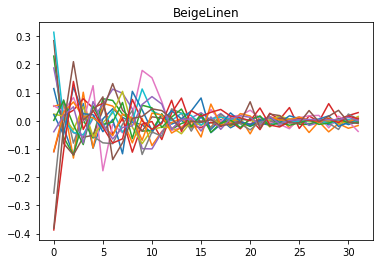

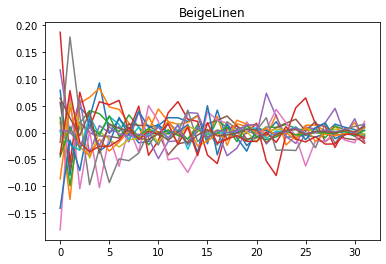

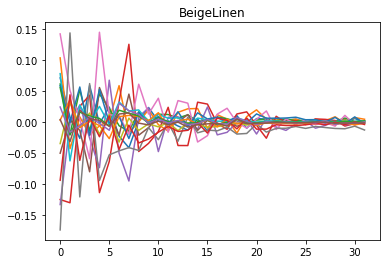

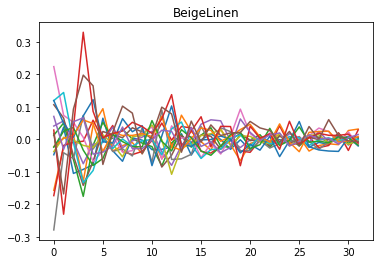

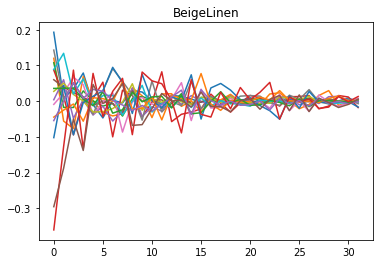

In [35]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

data_array = []
labels = []
for (sample, _, label) in ds:
    data_array.append(sample)
    labels.append(label)
    plt.plot(sample)
    plt.title(ds.get_texture_name(label))
    plt.show()

# Compress data with Tucker decomposition
1. Compute covariance matrix for each multi-channel frequency series
2. Stack covariance matrix into a 3D covariance tensor $T \in \mathbb{R}^{C \times C \times N}$
3. Use core tensor $\mathcal{G}$ of the Tucker decomposition $T = \mathcal{G} \times_1 U_1 \times_2 U_2 \times_3 U_3$ as a compressed representation
4. Visualize the latent vectors

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from numpy.fft import fft
from skfda import FDataGrid
from skfda.representation import basis
from tensorly.decomposition import non_negative_tucker, tucker
from tensorly.tenalg import mode_dot

plt.rcParams['figure.dpi'] = 150
%matplotlib notebook

N_BASIS = 65
STRIDE = 128
WINDOW_SIZE = 256
RANK = 3

fd_basis = basis.Fourier([0, 2 * np.pi], n_basis=N_BASIS, period=1)

def compute_cov_fda(data):
    ''' Compute covariance matrix with functional basis decomposition.'''
    fd = FDataGrid(data.T).to_basis(fd_basis)
    coeffs = fd.coefficients.squeeze()
    return np.cov(coeffs[:, 1:].T)

cov_array = []
labels, params = [], []

for sample, param, label in ds:
    cov_array.append(compute_cov_fda(sample))
    labels.append(ds.get_texture_name(label))
    params.append(param)
    
cov_tensor = np.transpose(np.asarray(cov_array), [1, 2, 0])
_, factors = non_negative_tucker(cov_tensor, rank=(RANK, RANK, cov_tensor.shape[2]))
covM = mode_dot(cov_tensor, factors[1].T, 1)
covM = mode_dot(covM, factors[0].T, 0)
covM = covM.reshape(RANK * RANK, len(labels)).T
M = (covM - np.min(covM))/(np.max(covM) - np.min(covM)) * 255

In [ ]:
M3d = M[:, :3]

df0 = pd.DataFrame(labels, columns=["texture"])
df1 = pd.DataFrame(params, columns=["pressure", "speed"])
df2 = pd.DataFrame(M3d, columns=["x1", "x2", "x3"])
df  = pd.concat([df0, df1, df2], axis=1)

textures = df["texture"].unique()
pressures = df["pressure"].unique()
speeds = df["speed"].unique()
cmap = plt.cm.get_cmap("plasma", len(textures))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i, texture in enumerate(textures):
    X = df[df["texture"] == texture]
    x1, x2, x3 = X['x1'], X['x2'], X['x3'] 
    ax.scatter(x1, x2, x3, s=20, c=np.tile(cmap(i), (len(x1), 1)))
    ax.legend(textures)

plt.show()

In [ ]:
from sklearn import neighbors, datasets

n_neighbors = 10
train_ratio = 0.7

y = np.array(labels)
index = np.arange(len(y), dtype=int)
np.random.shuffle(index)
train_id = index[:int(train_ratio * len(index))]

clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
clf.fit(M[train_id, :], y[train_id])
rate = np.sum(clf.predict(M) == y)/len(y)
print("Classification accuracy: {:.2f}%".format(rate * 100))

# Construct RNN-AutoEncoder (RAE)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence


class Encoder(nn.Module):
    """ Recurent Variational Autoencoder """
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, device, dropout=0.3):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_var = nn.Linear(hidden_dim, output_dim)
        
        self.to(device)
        
    def forward(self, x):
        packed_in = pack_padded_sequence(x[0].to(self.device), x[1].cpu().numpy(), batch_first=True)
        rnn_out, self.hidden = self.rnn(packed_in)
        x_in = self.hidden[-1].squeeze()
        mu = self.fc_mu(x_in)
        var = self.fc_var(x_in)
        
        return mu
    
    def init_hidden(self, batch_dim):
        return (torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device),
                torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device))


class RVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim, extra_dim, output_dim, n_layers, device):
        super(RVAE, self).__init__()
        self.device = device
        
        self.encoder = Encoder(input_dim, hidden_dim, encoding_dim, n_layers, device)
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        encoded = self.encode(x[:2])
        # x_in = torch.hstack([encoded, x[2].to(self.device)])
        y = self.classifier(encoded)

        return y

    def encode(self, x):
        return self.encoder(x)
    
""" Custom collate functions"""

class PadSequence(object):
    def __call__(self, batch):
        # Each element in "batch" is a tuple (data, label).
        # Sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        # Get each sequence and pad it
        sequences = [torch.tensor(x[0], dtype=torch.float).unsqueeze(1) for x in sorted_batch]
        sequences_padded = pad_sequence(
            sequences, batch_first=True)
        # Store the length of each sequence
        lengths = torch.tensor([len(x) for x in sequences])
        params = torch.tensor(list(map(lambda x: x[1], sorted_batch)), dtype=torch.float)
        labels = torch.tensor(list(map(lambda x: x[2], sorted_batch)))
        return sequences_padded, lengths, params, labels

# Train the network

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.utils.data import DataLoader

BATCH_SIZE = 2
EPOCHS = 100
INPUT_DIM = 1
NUM_CLASS = 4

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_loader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=PadSequence(), num_workers=6, shuffle=True)
rvae = RVAE(input_dim=INPUT_DIM, hidden_dim=16, encoding_dim=3, extra_dim=2, output_dim=NUM_CLASS, n_layers=3, device=device)
loss_list = []

def train_once(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x)
    target = y.to(device)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    
def train_model(data_loader, model):
    optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    criterion = nn.CrossEntropyLoss()
    # loss_list = []
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        
        for i, (batch, lengths, params, targets) in enumerate(data_loader):
            loss = train_once((batch, lengths, params), targets, model, optimizer, criterion)
            running_loss += loss
            loss_list.append(loss)
            
            if i % 10 == 9:
                print('Epoch {}, {:.2f}% - loss: {:.6f}'.format(epoch + 1, 100.0 * (i + 1.0) / len(data_loader), running_loss / 10))
                running_loss = 0.0
                
    print("Training finished.")
    plt.figure()
    plt.plot(loss_list)
    plt.title("Training Recurrent Autoencoder")
    plt.xlabel("Run")
    plt.ylabel("Loss")
    plt.show()
    
train_model(train_loader, rvae)